# Identificación de actividades a bordo utilizando salida del detector

El objetivo de este cuaderno es desarrollar un modelo de clasificación de actividades a bordo de un buque a partir del entrenamiento de un modelo supervisado. 

- Video utilizado: [Maniobra langostino mirta r desde gopro (youtube)](https://www.youtube.com/watch?v=WgCe0tMO4lA). 
- Duración 10:07 (diez minutos, siete segundos).
- Descripción: Maniobra de pesca buque Mirta R. Pesca de langostino con tangones provincia de Chubut Rawson Playa Union.


Dado que sólo se dispone de un video, se adopta la siguiente aproximación:

1. Preparación del dataset
    1. Se ejecuta el detector YOLOv4 sobre el video, obteniendo como salida un archivo CSV donde cada fila contiene una detección encontrada en cada frame (puede haber más de una fila por frame).
    2. Se realiza un etiquetado manual, identificando en el video actividades de interés. Se agrega al dataset del paso anterior una nueva columna con una variable categórica indicando el tipo de actividad.
2. Desarrollo de modelos de aprendizaje supervisado
    1. Se incorporan variables (features), teniendo como única restricción que las mismas no pueden usar datos del futuro (en vistas a utilizarlas en tiempo real).
    2. Se particiona el dataset en entrenamiento y evaluación.
3. Desarrollo de modelos de aprendizaje no supervisado
    1. Se ensayan distintas configuraciones de K-Means.
    
    
Referencias de interés para entender el dominio del problema:

- [Resolucion 7 (17-05-18) Medidas de administracion langostino.pdf](https://cfp.gob.ar/resoluciones/Resolucion%207%20(17-05-18)%20Medidas%20de%20administracion%20langostino.pdf)
- [Informe INIDEP - Langostino (PLeoticus muelleri)](https://www.inidep.edu.ar/wp-content/uploads/Langostino.pdf)
- [Infografía Langostino Pleoticus muelleri](https://www.argentina.gob.ar/sites/default/files/inidep_infografia_langostino.pdf)

In [288]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import cv2
import os
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATASET_PATH="../../data/"
!ls {DATASET_PATH}

datasets  media  models  other


In [3]:
def load_detections_csv(filename):
    det_columns = ["frame_num","class_idx", "x","y","w","h","score"]
    df = pd.read_csv(filename,names=det_columns)
    return df
df_det = load_detections_csv(DATASET_PATH+"other/detections.csv")
df_det.head()

,frame_num,class_idx,x,y,w,h,score
0,0,0,860.0,361.0,140.0,137.0,0.742915
1,0,0,696.0,387.0,111.0,104.0,0.620522
2,1,0,860.0,361.0,140.0,137.0,0.742915
3,1,0,696.0,387.0,111.0,104.0,0.620522
4,2,0,862.0,361.0,137.0,137.0,0.657860


## 1. Etiquetado manual

Sin contar aún con un conocimiento profundo de la técnica de pesca de langostino en barcos tangoneros y la terminología utilizada para describir los pasos involucrados, se propone la siguiente clasificación preliminar, a ser revisada con expertos:

|Evento             |Descripción                   | Desde | Hasta |
|-------------------|------------------------------|-------|-------|
| Levado de redes 1 | De 1 a 3 operadores realizan maniobras de recogimiento del cabo en el puente (centro de la imagen).| 00:00 | 00:48 |
| Levado de redes 2 | 2 operadores tiran de los cabos para recoger las redes.| 01:05 | 01:40 |
| Levado de redes 3 | Se recogen los barcos y los operadores se reubican en cubierta | 02:45 | 05:30 |
| Redes recogidas   | Las redes están visibles en el video. Puede ser de interés para estimar el volumen de captura | 05:33 | 05:47 |
| Descarga de redes.| Se vacía el contenido de las redes en la cubierta | 05:47 | 07:20 |
| Redes descargadas / clasificación | El barco se desplaza a mayor velocidad y algunos operadores clasifican la captura, arrojando algunos especímenes y preparando recipientes para otros. | 07:20 | 10:03 |

### 1.1. Identificación de actividades

In [5]:
activity = [    
    ("lr1"   , '00:00:00', '00:00:48' ),
    ("lr2"   , '00:01:05', '00:01:40' ),
    ("lr3"   , '00:02:45', '00:05:30' ),
    ("rr"    , '00:05:33', '00:05:47' ),
    ("dr"    , '00:05:48', '00:07:19' ),
    ("rdc"   , '00:07:20', '00:10:03' ),
]

df_activity = pd.DataFrame(activity, columns=["cat","from","to"])
df_activity

,cat,from,to
0,lr1,00:00:00,00:00:48
1,lr2,00:01:05,00:01:40
2,lr3,00:02:45,00:05:30
3,rr,00:05:33,00:05:47
4,dr,00:05:48,00:07:19
5,rdc,00:07:20,00:10:03


In [343]:
def prepare_dataset(df,df_activity):
    df_det = df.copy()
    total_frames = df_det.frame_num.max()-df_det.frame_num.min()

    # Tiempo relativo
    fps = 29.0
    df_det['ts'] = df_det['frame_num']/fps
    df_det['ts'] = pd.to_timedelta(df_det['ts'], unit='s')

    # Centrado de coordenadas de BBs
    df_det['xc'] = df_det['x']+df_det['w']/2
    df_det['yc'] = df_det['y']+df_det['h']/2

    # Área de los BBs
    df_det['area'] = df_det['w']*df_det['h']
    
    # Categoría
    df_det['target'] = np.nan
    for x in df_activity.iterrows():
        df_det.loc[(df_det.ts>=x[1]["from"]) & (df_det.ts<=x[1]["to"]),"target"] = x[1]["cat"] 

    return df_det

df_modified = prepare_dataset(df_det,df_activity)
df_modified.head()

,frame_num,class_idx,x,y,w,h,score,ts,xc,yc,area,target
0,0,0,860.0,361.0,140.0,137.0,0.742915,0 days 00:00:00,930.0,429.5,19180.0,lr1
1,0,0,696.0,387.0,111.0,104.0,0.620522,0 days 00:00:00,751.5,439.0,11544.0,lr1
2,1,0,860.0,361.0,140.0,137.0,0.742915,0 days 00:00:00.034482759,930.0,429.5,19180.0,lr1
3,1,0,696.0,387.0,111.0,104.0,0.620522,0 days 00:00:00.034482759,751.5,439.0,11544.0,lr1
4,2,0,862.0,361.0,137.0,137.0,0.657860,0 days 00:00:00.068965517,930.5,429.5,18769.0,lr1


In [354]:
df_test = df_modified.iloc[0:10]

In [380]:
def center_of_mass(r,axis):
    n = len(r)    
    print(r)
    return [np.sum(r.xc.values)/ n,np.sum(r.yc.values)/ n]

df_test.groupby("frame_num").apply(center_of_mass,axis=1)

frame_num
0    [840.75, 434.25]
1    [840.75, 434.25]
2      [840.5, 434.0]
3     [843.25, 432.5]
4     [842.25, 432.5]
dtype: object

In [353]:
df_modified.groupby("frame_num").mean()[['xc','yc','area']]

,xc,yc,area
frame_num,,,
0,840.750000,434.250000,15362.000000
1,840.750000,434.250000,15362.000000
2,840.500000,434.000000,14895.000000
3,843.250000,432.500000,13548.000000
4,842.250000,432.500000,14042.000000
...,...,...,...
18200,692.666667,565.333333,48408.666667
18201,669.000000,584.625000,44559.500000
18202,669.000000,584.250000,43775.750000


In [346]:
df_modified.groupby("frame_num").mean()[['xc','yc','area']]

,xc,yc,area
frame_num,,,
0,840.750000,434.250000,15362.000000
1,840.750000,434.250000,15362.000000
2,840.500000,434.000000,14895.000000
3,843.250000,432.500000,13548.000000
4,842.250000,432.500000,14042.000000
...,...,...,...
18200,692.666667,565.333333,48408.666667
18201,669.000000,584.625000,44559.500000
18202,669.000000,584.250000,43775.750000


## 2. Desarrollo de modelos supervisados

### 2.1 Preparación de datos

#### 2.1.1 Tratamiento de valores faltantes

Porcentaje de NaNs.

In [151]:
print("NaNs: {:.2f}%".format(df_modified.isnull().sum().sum()/len(df_modified)*100))

NaNs: 23.26%


Variante 1. Tratamiento de NaNs por Complete Case Analisis (https://en.wikipedia.org/wiki/Listwise_deletion).

In [152]:
df_cca = df_modified[df_modified['target'].notna()]
df_cca.head()

AttributeError: 'DataFrame' object has no attribute 'target'

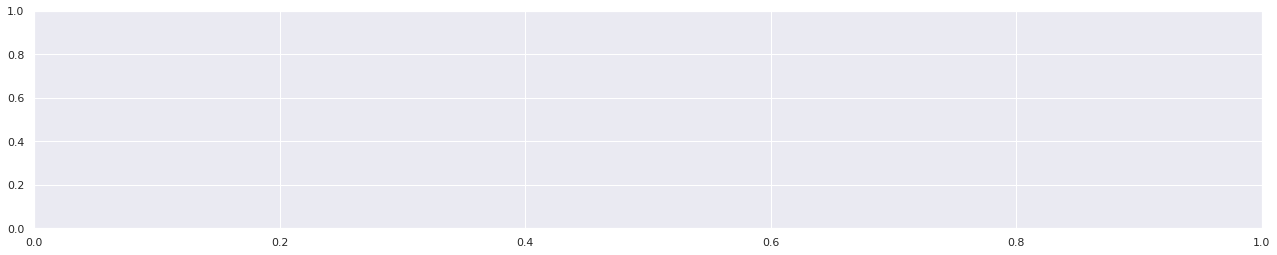

In [342]:
def plot_class_counts(df):
    fig,axes = plt.subplots(1,1,figsize=(22,4))
    ((df.target.value_counts()/len(df.target))*100).plot.bar(ax=axes);
    axes.axhline(5,color="r");
    axes.set_xlabel("Actividad")
    axes.set_ylabel("% del total de muestras")
    axes.set_title("Representación de cada categoría en dataset")
    axes.legend(["5%","Muestras por categoría (%)"])
    
plot_class_counts(df_cca)    

Variante 2. Asignación de NaNs a categoría especial.

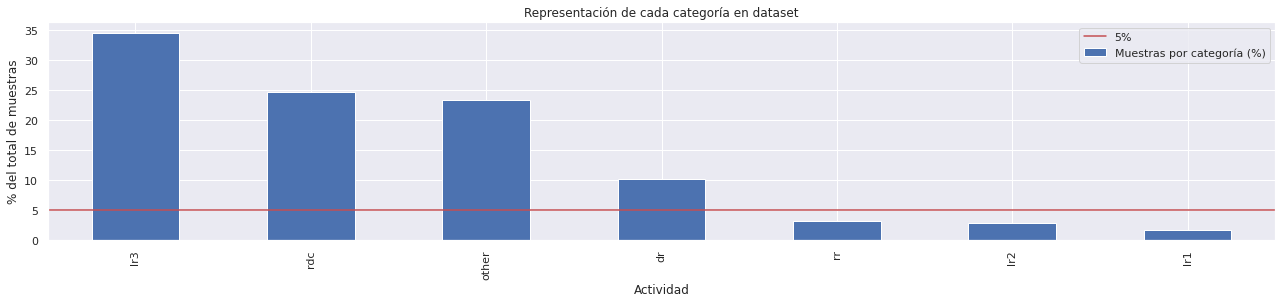

In [341]:
df_other = df_modified.copy()
df_other.loc[df_other.target.isna(),'target'] = "other"
plot_class_counts(df_other)  

#### 2.1.2 Categorías poco frecuentes

En los gráficos anteriores se observa que las categorías 'lr1' tienen baja representación en el dataset (menos del 5%). Se agruparán estas tres en una misma categoría.

In [156]:
def reassign_categories(df,categories,target_cat):
    for cat in categories:
        df.loc[df.target==cat,'target'] = target_cat
    return df

In [157]:
low_freq_cats = ["lr1","lr2","lr3"]
df_other = reassign_categories(df_other,low_freq_cats,"lr")
df_cca = reassign_categories(df_cca,low_freq_cats,"lr")

/home/nhorro/anaconda3/envs/yolov4-gpu/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


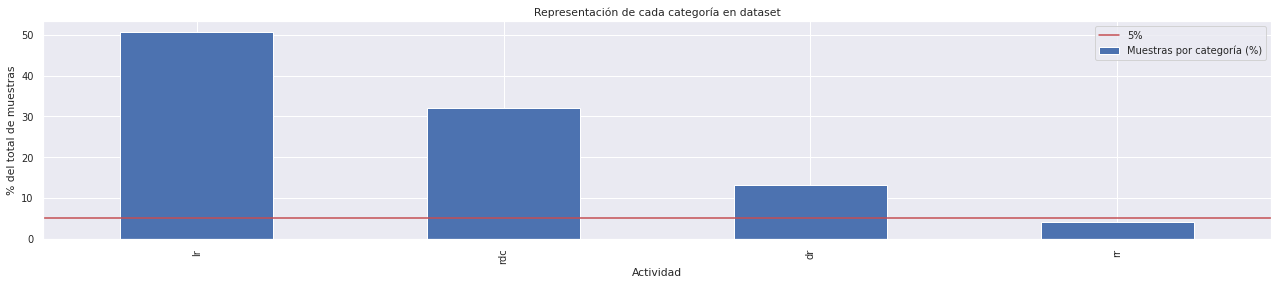

In [177]:
plot_class_counts(df_cca)  

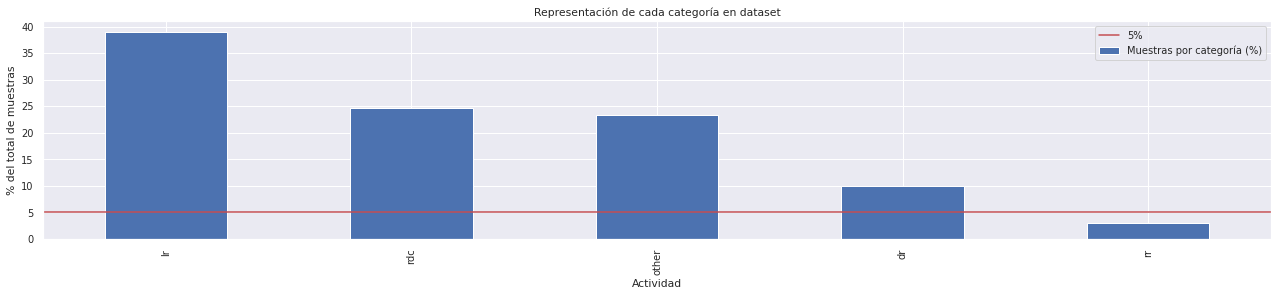

In [178]:
plot_class_counts(df_other)  

#### 2.1.3 Balance del dataset

In [161]:
#FIXME
#Evaluar conveniencia de:
# - Downsampling
# - Upsampling. SMOTE, u otro
# - Métricas no afectadas por desbalance de dataset

#### 2.1.4 Estudio de distribución y transformaciones

###### Normalidad

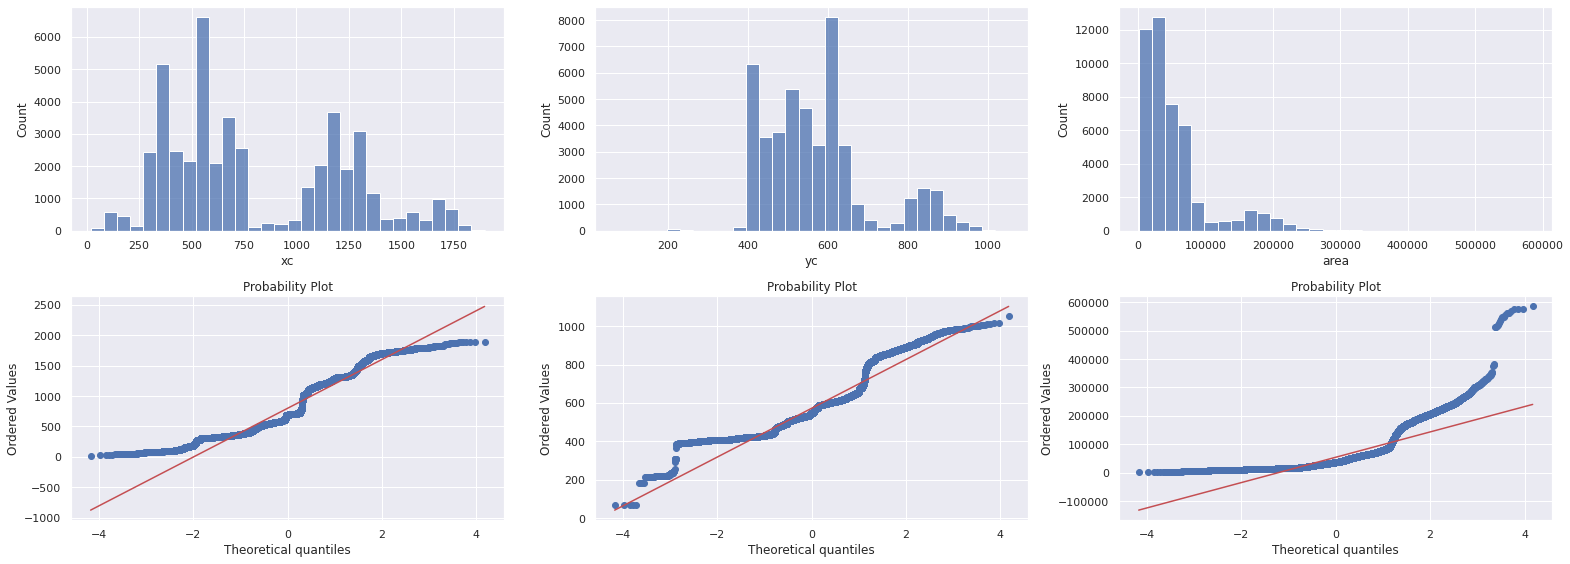

In [296]:
fig,axes=plt.subplots(2,3,figsize=(22,8))

sns.histplot(df_other['xc'], bins=30,ax=axes[0,0])
stats.probplot(df_other['xc'], dist="norm", plot=axes[1,0])

sns.histplot(df_other['yc'], bins=30,ax=axes[0,1])
stats.probplot(df_other['yc'], dist="norm", plot=axes[1,1])

sns.histplot(df_other['area'], bins=30,ax=axes[0,2])
stats.probplot(df_other['area'], dist="norm", plot=axes[1,2]);

fig.tight_layout()

###### Estudio de colinealidad

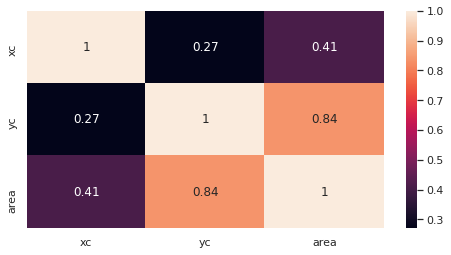

In [300]:
# Matriz de correlación, redondeo a 2 decimales
correlation_matrix = df_cca[["xc","yc","area"]].corr().round(2)
fig,axes = plt.subplots(1,1,figsize=(8,4))
sns.heatmap(data=correlation_matrix, annot=True,ax=axes);

###### Estudio de valores extremos (outliers)

In [303]:
def outlier_diagnostic_plots(df, variable):
    fig,axes = plt.subplots(1,3,figsize=(20,4))

    sns.histplot(df[variable], bins=30,ax=axes[0])
    axes[0].set_title('Histograma')
    
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    axes[1].set_title('QQ')
    
    # boxplot    
    sns.boxplot(y=df[variable],ax=axes[2])
    axes[2].set_title('Box&Whiskers')

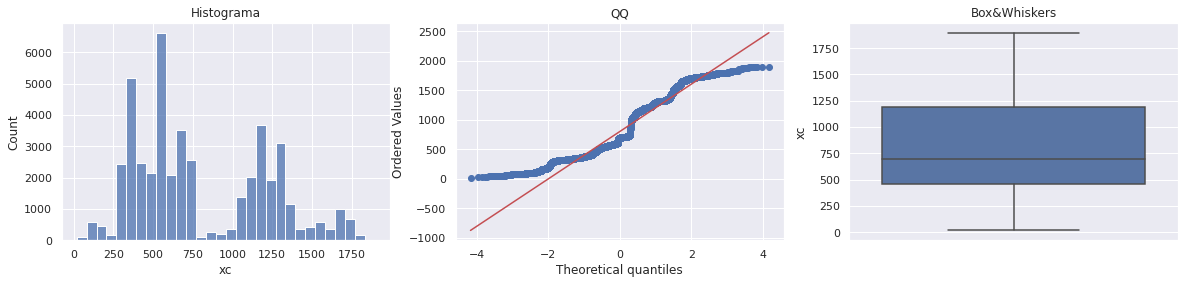

In [310]:
outlier_diagnostic_plots(df_other, 'xc')

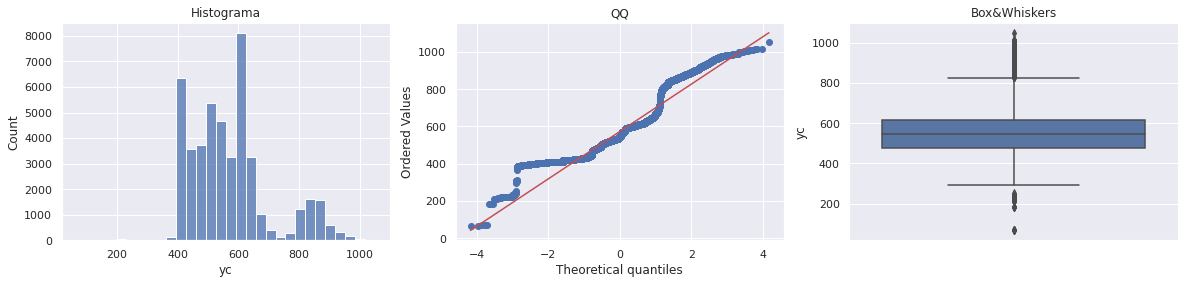

In [311]:
outlier_diagnostic_plots(df_other, 'yc')

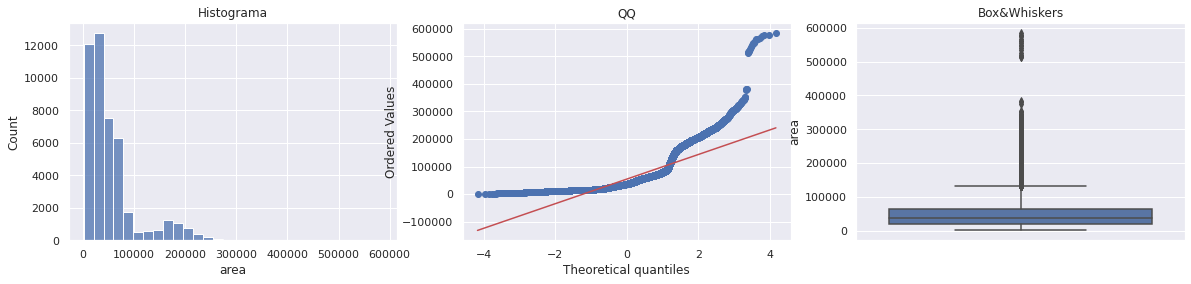

In [312]:
outlier_diagnostic_plots(df_other, 'area')

###### Estudio de rango de las variables de entrada

In [313]:
for col in ["xc","yc","area"]:
    print(col, 'rango: ', df_other[col].max() - df_other[col].min())

xc rango:  1877.5
yc rango:  984.5
area rango:  584169.0


#### 2.1.5 Ingeniería de features

In [314]:
#FIXME
#Pendiente, generar nuevas features

### 2.2 Entrenamiento de modelos

#### 2.2.1 Preparación común de datasets CCA y OTHER

In [315]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

feature_cols = ["xc","yc","area"]

def prepare_dataset(df,feature_cols):
    X = df[feature_cols]
    y = df['target']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)
    
    label_enc = LabelEncoder()

    label_enc.fit(y_train)
    y_train_encoded = label_enc.transform(y_train)
    y_test_encoded = label_enc.transform(y_test)
    
    return X_train, X_test, y_train_encoded, y_test_encoded

X_train_cca, X_test_cca, y_train_cca, y_test_cca = prepare_dataset(df_cca,feature_cols)
X_train_other, X_test_other, y_train_other, y_test_other = prepare_dataset(df_other,feature_cols)
    
print("Tamaño de train:", X_train.shape,y_train_encoded.shape)
print("Tamaño de test:", X_test.shape,y_test_encoded.shape)

Tamaño de train: (28225, 3) (28225,)
Tamaño de test: (7057, 3) (7057,)


##### 2.2.2 Entrenamiento de modelos

In [325]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import QuantileTransformer

In [329]:
from sklearn.pipeline import Pipeline

models_to_test = [
    {
        "name": "LogisticRegression",
        "model": Pipeline( steps=[
            ('scaler', StandardScaler()),
            ('model', LogisticRegression(max_iter=2000, solver='lbfgs'))
        ])
    },
    
    {
        "name": "LogisticRegressionTx",
        "model": Pipeline( steps=[
            ('qt', QuantileTransformer(n_quantiles=500, output_distribution='normal',random_state=42)),
            ('scaler', StandardScaler()),
            ('model', LogisticRegression(max_iter=2000, solver='lbfgs'))
        ])
    },
    
    {
        "name": "AdaBoostClassifier",
        "model": Pipeline( steps=[
            ('scaler', StandardScaler()),
            ('model', AdaBoostClassifier())
        ])
    },
    
    {
        "name": "RandomForestClassifier",
        "model": Pipeline( steps=[
            ('scaler', StandardScaler()),
            ('model', RandomForestClassifier())
        ])
    },
    
    {
        "name": "GradientBoostingClassifier",
        "model": Pipeline( steps=[
            ('scaler', StandardScaler()),
            ('model', GradientBoostingClassifier())
        ])
    }
]
    
results = {}

for idx, m in enumerate(models_to_test):    
    
    model_name = m["name"]
    model = m["model"]
    
    results[model_name] = {}
        
    # Entrenar c/ dataset CCA
    model.fit(X_train_cca,y_train_cca)
    y_train_pred = model.predict_proba(X_train_cca)
    
    start = time.time()     
    y_test_pred = model.predict_proba(X_test_cca)
    inference_time = (time.time() - start)/len(X_test_cca)
    
    train_score = roc_auc_score(y_train_cca,y_train_pred,multi_class='ovr' )
    test_score = roc_auc_score(y_test_cca,y_test_pred,multi_class='ovr' )
    
    results[model_name]["train_score_cca"] = train_score
    results[model_name]["test_score_cca"] = test_score
    results[model_name]["inference_time_cca"] = inference_time
    
    # Entrenar c/ dataset OTHER    
    model.fit(X_train_other,y_train_other)
    y_train_pred = model.predict_proba(X_train_other)
    
    start = time.time()        
    y_test_pred = model.predict_proba(X_test_other)
    inference_time = (time.time() - start)/len(X_test_other)
    
    train_score = roc_auc_score(y_train_other,y_train_pred,multi_class='ovo' )
    test_score = roc_auc_score(y_test_other,y_test_pred,multi_class='ovo' )
    
    results[model_name]["train_score_other"] = train_score
    results[model_name]["test_score_other"] = test_score
    results[model_name]["inference_time_other"] = inference_time
    
df_results = pd.DataFrame(results).T
df_results    

,train_score_cca,test_score_cca,inference_time_cca,train_score_other,test_score_other,inference_time_other
LogisticRegression,0.608405,0.605206,2.605998e-07,0.608131,0.603420,2.301610e-07
LogisticRegressionTx,0.603037,0.603849,9.976651e-07,0.585244,0.576671,9.434723e-07
AdaBoostClassifier,0.738601,0.734118,9.776463e-06,0.736471,0.727031,1.128230e-05
RandomForestClassifier,0.999999,0.954744,2.108336e-05,1.000000,0.943116,2.464940e-05
GradientBoostingClassifier,0.910213,0.896618,5.937118e-06,0.889877,0.876024,7.387411e-06


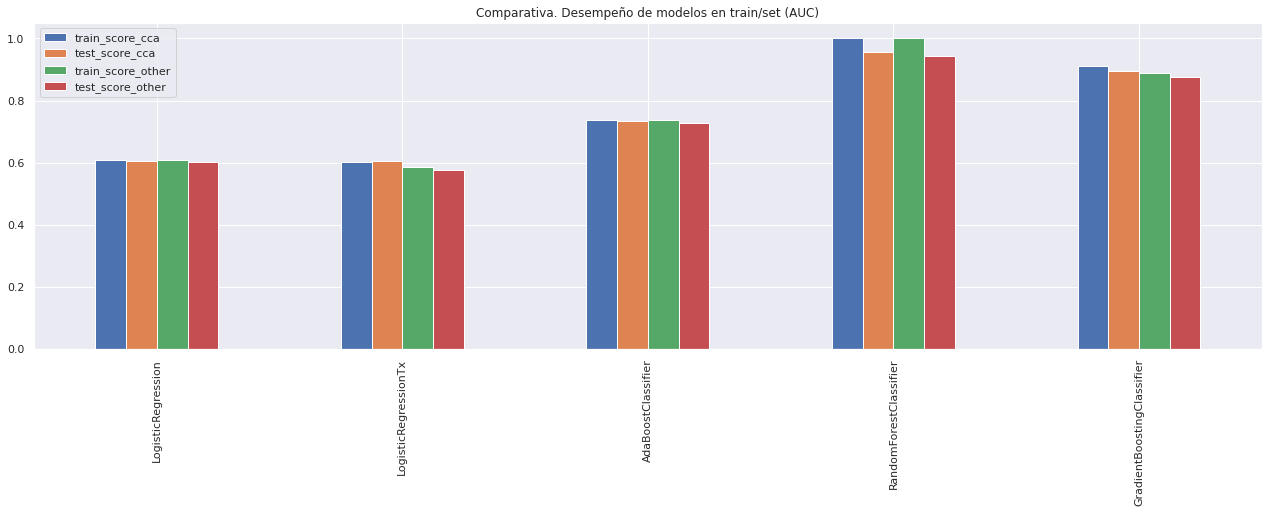

In [330]:
model_scoring_cols = [
    "train_score_cca","test_score_cca",
    "train_score_other","test_score_other"
]  
df_results[model_scoring_cols].plot.bar(figsize=(22,6)).set_title("Comparativa. Desempeño de modelos en train/set (AUC)");

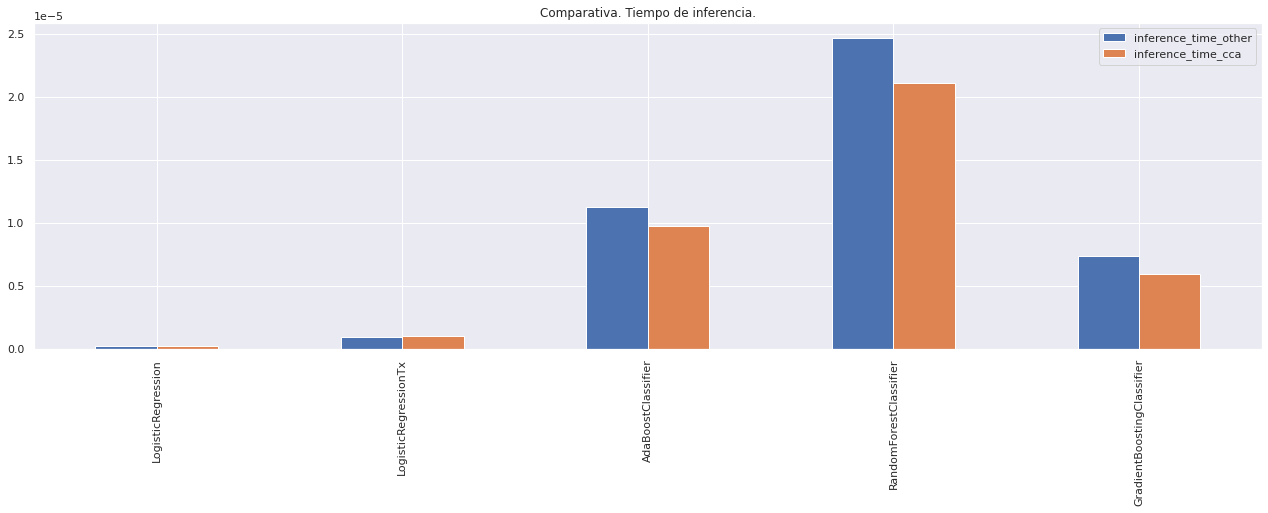

In [331]:
model_timing_cols = [
    "inference_time_other",
    "inference_time_cca"
]
df_results[model_timing_cols].plot.bar(figsize=(22,6)).set_title("Comparativa. Tiempo de inferencia.");

## 3. Desarrollo de modelos no supervisados

In [332]:
df_modified.head()

,frame_num,class_idx,x,y,w,h,score,ts,xc,yc,area,target
0,0,0,860.0,361.0,140.0,137.0,0.742915,0 days 00:00:00,930.0,429.5,19180.0,lr1
1,0,0,696.0,387.0,111.0,104.0,0.620522,0 days 00:00:00,751.5,439.0,11544.0,lr1
2,1,0,860.0,361.0,140.0,137.0,0.742915,0 days 00:00:00.034482759,930.0,429.5,19180.0,lr1
3,1,0,696.0,387.0,111.0,104.0,0.620522,0 days 00:00:00.034482759,751.5,439.0,11544.0,lr1
4,2,0,862.0,361.0,137.0,137.0,0.657860,0 days 00:00:00.068965517,930.5,429.5,18769.0,lr1


In [335]:
from sklearn.cluster import KMeans

X = df_modified[['xc','yc','area']]
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

array([[   693.14921881,    633.21891425,  66875.78025776],
       [  1317.86185162,    841.97117173, 185536.1523042 ],
       [   761.03765138,    493.45633028,  24602.49313761]])

# Borrador
<hr/>

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer

ct = ColumnTransformer(
     [
         ( "norm1", Normalizer(norm='l1'), [0, 1]),
         ( "norm2", Normalizer(norm='l1'), slice(2, 4))
     ])

In [266]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score